</H1><p style="text-align: center;">Universidad Complutense de Madrid</p></H1>
</H2><p style="text-align: center;">Programacion Aplicada a las Ciudades Inteligentes</p></H2>
</H3><p style="text-align: left;">Proyecto Final</p></H3>
</H3><p style="text-align: left;">Carolina Pirane Vega</p></H3>

</H3><b><p style="text-align: center;">Configuración de Bibliotecas y Importación de Datos</p></b></H3>

Importando las bibliotecas que voy a necesitar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.preprocessing import scale

Importando el archivo CSV mediante la función read_csv de Pandas, utilizando 'r' para lectura e indicando el separador utilizado en el archivo.

In [2]:
datos_madrid_trafico=pd.read_csv(r"/Users/carolinavega/Documents/UCM/Python/10-2023.csv", sep=";")

Explorando los datos importados para obtener información sobre su contenido.

In [ ]:
datos_madrid_trafico.head()

Preparando los datos: Utilizando Pandas DataFrame, filtro los sensores ubicados en C30, M-30 y en zonas urbanas, creando un conjunto de datos exclusivo con esta selección. El filtro por tipo de elemento es esencial para la separación de los datos.

In [3]:

c30_sensors = pd.DataFrame(datos_madrid_trafico[datos_madrid_trafico['tipo_elem'] == 'C30'])
m30_sensors =pd.DataFrame(datos_madrid_trafico[datos_madrid_trafico['tipo_elem'] == 'M30'])
urb_sensors =pd.DataFrame(datos_madrid_trafico[datos_madrid_trafico['tipo_elem'] == 'URB'])
sensores_m30_urb =pd.DataFrame(datos_madrid_trafico[datos_madrid_trafico['tipo_elem'].isin(['M30', 'URB'])])



</H3><b><p style="text-align: center;">Identificación de Datos Perdidos para Mejorar la Calidad del Análisis de Datos</p></b></H3>

Missing data de los Datos del sensores C30 M30 URB

Para el análisis de datos faltantes, he creado una función `datos_faltantes` que trae todas las columnas del DataFrame original en una columna llamada 'Columnas'. Luego, para cada columna, se crea una línea. Para identificar la cantidad de ceros, se igualan los valores a cero, se calcula la media y se multiplica por 100. Este proceso se repite para las columnas que contienen el valor NaN y para los valores nulos.
Esta función devuelve un DataFrame con información sobre el porcentaje de ceros, NaN y valores nulos para cada columna del DataFrame original, lo que facilita la identificación de datos faltantes durante el análisis de datos.

In [4]:
def datos_faltantes(dataframe):
    percentual_datos_faltantes = pd.DataFrame({
    'Columnas': dataframe.columns,
    'Porcentaje de Ceros': (dataframe == 0).mean() * 100,
    'Porcentaje de NaN': dataframe.isna().mean() * 100,
    'Porcentaje de Valores Nulos': (dataframe.isnull() | (dataframe == '')).mean() * 100  
})

    return percentual_datos_faltantes

En este análisis de los datos de los sensores en M30, se examina la existencia de ceros, valores nulos o 'na' para evaluar la calidad de los datos y así identificar los sensores con registros más fiables

In [5]:
missing_data_percentages_m30 = datos_faltantes(m30_sensors)
missing_data_percentages_m30

,Columnas,Porcentaje de Ceros,Porcentaje de NaN,Porcentaje de Valores Nulos
id,id,0.000000,0.000000,0.000000
fecha,fecha,0.000000,0.000000,0.000000
tipo_elem,tipo_elem,0.000000,0.000000,0.000000
intensidad,intensidad,3.837723,0.000000,0.000000
ocupacion,ocupacion,18.584521,0.000000,0.000000
carga,carga,4.170591,0.000000,0.000000
vmed,vmed,2.755902,1.105246,1.105246
error,error,0.000000,3.088523,3.088523
periodo_integracion,periodo_integracion,0.000000,0.000000,0.000000


Resultados del análisis de sensores en M30: Este análisis revela que los sensores urbanos presentan un 3.83% de ceros en los datos de intensidad, un 18.58% en los datos de ocupación, un 4.17% en los datos de carga y un 2.75% en los datos de velocidad. Además de los ceros, se observan valores NaN y nulos, que en cualquier forma de análisis no resultan relevantes. Sin embargo, para los propósitos de los ejercicios, los datos más utilizados son velocidad e intensidad, y las pérdidas debidas a la cantidad de datos no son significativas hasta el punto de afectar los resultados.

Se repetirá el análisis para los sensores Urbanos.

In [ ]:
missing_data_percentages_urb = datos_faltantes(urb_sensors)

missing_data_percentages_urb

Resultado del análisis de sensores urbanos: Según este análisis, se observa que los sensores urbanos presentan un 1.39% de ceros en los datos de intensidad, un 23.78% en los datos de ocupación, un 4.43% en los datos de carga y un 100% de ceros en los datos de velocidad. Es importante destacar que los datos de velocidad de estos sensores, aunque se utilicen en este estudio, contienen ceros, lo que puede afectar los resultados en un análisis más amplio

Se repetirá el análisis para los sensores en C30

In [ ]:
missing_data_percentages_c30 = datos_faltantes(c30_sensors)

missing_data_percentages_c30

Resultado del análisis de sensores C30: Según este análisis, se observa que los sensores en C30 tienen un 6.16% de ceros en los datos de intensidad, un 11.29% en los datos de ocupación, un 100.00% de ceros en los datos de carga y un 6.16% de ceros en los datos de velocidad. Además, presentan un bajo porcentaje de NaN en ocupación, lo cual no afectará este estudio ya que no es un objetivo relevante.

Resultado Final: A la luz de los resultados individuales de los análisis, no se ha identificado la necesidad de aplicar algún tratamiento a los datos, a excepción de la consideración de que en los sensores urbanos, los datos de velocidad posiblemente no reflejen con precisión la realidad.

</H3><b><p style="text-align: center;">Análisis de Datos Discrepantes: Mejorando la Calidad del Análisis mediante la Identificación de Valores Atípicos en Velocidad e Intensidad</p></b></H3>


Desarrollo de una Función para Visualizar Boxplots en el Análisis Requerido

Esta función, llamada `analisis_boxplot`, genera un boxplot para una columna específica de un DataFrame dado. Utiliza la biblioteca seaborn (sns) para crear el gráfico de caja, mostrando la distribución y las estadísticas de la variable especificada. El título y las etiquetas del eje se personalizan según la columna proporcionada. Finalmente, el gráfico se muestra mediante plt.show().

In [6]:
def analisis_boxplot(dataframe, columna):
    # Box plot
    sns.boxplot(data=dataframe, x=columna)
    plt.title(f'Box Plot {columna}')
    plt.xlabel(columna)
    plt.show()

Una técnica para manejar outliers sin afectar los datos es la winsorización, que reemplaza los valores extremos con los correspondientes a los percentiles. Esto ayuda a suavizar el impacto de los outliers en los análisis estadísticos sin eliminar completamente la información.


Esta función `winsorize_and_boxplot` realiza dos acciones principales: la winsorización, que trata los valores extremos en la columna especificada ajustándolos a los percentiles 5 y 90, lo que ayuda a suavizar el impacto de los outliers y la creación de un boxplot antes y después de la winsorización.

In [7]:
#Una funciona para winsorizar los datos
def winsorize_and_boxplot(dataframe, column):
    # Obtener los quartiles para tratar los outliers
    values = dataframe[column].quantile([0.05, 0.9]).to_list()

    # Winsorizar
    dataframe[f'{column}_win'] = dataframe[column].clip(values[0], values[1])

    # Box plot antes y después de la winsorización
    dataframe[[column, f'{column}_win']].boxplot()
    plt.title(f'Box Plot Before and After Winsorization - {column}')
    plt.xlabel(column)
    plt.show()

Análisis de los Datos Atípicos en la M30

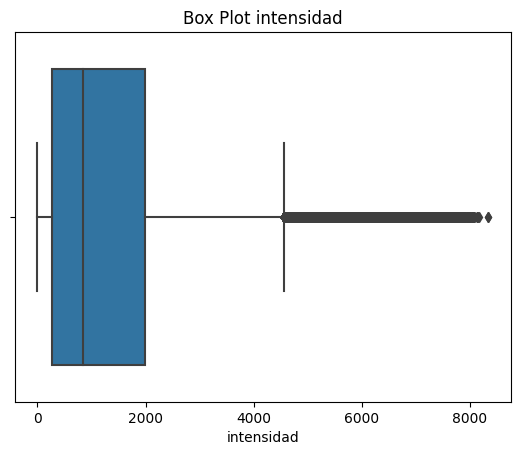

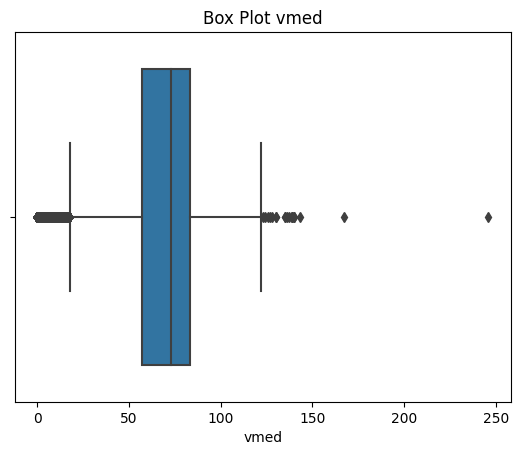

In [8]:
analisis_boxplot(m30_sensors, 'intensidad')
analisis_boxplot(m30_sensors, 'vmed')

En las dos analisis se pueden ver en los boxplots que hay muchos datos discrepantes, lo que voy hacer es analisar si con una winsorizacion estos datos quedan mas normalizados sin afectar sus informaciones.

In [ ]:
winsorize_and_boxplot(m30_sensors,'vmed')

Al observar el nuevo campo creado mediante la winsorización (vmed_win) y realizar un análisis comparativo con los datos originales, se aprecia que las líneas de la caja permanecen muy cercanas a lo que se tenía inicialmente. Se destaca que no hay presencia de outliers, y se nota que la línea superior se desplaza ligeramente más cerca de la caja en esta comparación.

In [ ]:
winsorize_and_boxplot(m30_sensors,'intensidad')


Al observar el nuevo campo creado mediante la winsorización (intensidad_win) y realizar un análisis comparativo con los datos originales, se aprecia que las líneas de la caja permanecen muy cercanas a lo que se tenía inicialmente. Se destaca que no hay presencia de outliers, y se nota que la línea superior se desplaza ligeramente más cerca de la caja en esta comparación.

C30 Aqui se repite el mismo analisis

In [ ]:
#analisis bloxplot de los datos discrepantes en intensidade sensor M30
analisis_boxplot(c30_sensors, 'intensidad')
analisis_boxplot(c30_sensors, 'vmed')

Aqui tambien se notan muchos datos discrepantes por lo qual ire tambiens proceder con la winsorizacion.

In [ ]:
winsorize_and_boxplot(c30_sensors,'vmed')

In [ ]:
winsorize_and_boxplot(c30_sensors,'intensidad')


Al observar el nuevo campo creado mediante la winsorización (vmed_win, intensidad_win) y realizar un análisis comparativo con los datos originales de intensidad y velocidad en C30, se aprecia que las líneas de la caja permanecen muy cercanas a lo que se tenía inicialmente. Se destaca que no hay presencia de outliers, y se nota que la línea superior se desplaza ligeramente más cerca de la caja en esta comparación

Repetimos mas una vez el analisi en sensores Urbanos

In [ ]:
#analisis bloxplot de los datos discrepantes en intensidade sensor M30
analisis_boxplot(urb_sensors, 'intensidad')
analisis_boxplot(urb_sensors, 'vmed')

Hice el mismo analisis con los datos urbanos, pero los datos de velocidad estan todos con ceros como ya habiamos visto en el analisis de los datos missing por esta razon solo hare la  la winsorizacion de los datos de intensidad.

In [ ]:
winsorize_and_boxplot(urb_sensors,'intensidad')

En los sensores urbanos, en la intensidad, se observa más o menos el mismo resultado de las demás analisis. Sin embargo, dado que la velocidad está completamente en ceros, el boxplot está vacío y no hay necesidad de realizar pruebas adicionales.

Los datos winsorizados son útiles para atenuar el impacto de valores atípicos en análisis de series temporales, machine learning, estudios comparativos y descriptivos. Esta técnica mejora la estabilidad de los datos, permitiendo una visión más precisa y equilibrada, especialmente en situaciones donde la presencia de outliers puede distorsionar las conclusiones de los análisis realizados. En este analisis podemo utilizar los datos Winsorizados para comparar los resultados.

<center>Primera parte: Conociendo a los datos que se van a manejar:</center>

- <b> Número de registros con los que se va a trabajar.<b>

Utilizo la función len para determinar la cantidad de sensores y presento la información en la pantalla mediante un print

In [ ]:

print("El numero de registros que exitens en el csv y que se vana utilizar en esta analisis es:",len(datos_madrid_trafico))

- <b> Número de sensores sensores_distintos que han realizado la recogida de datos.<b>

En primer lugar, creo una variable que almacena todos los tipos únicos de los sensores (tipo_elem) y uno que almacena todos los Id unicos de sensores(id). Entonces imprimo los resultados utilizando un print, mostrando únicamente la cantidad de valores de los tipos y de id distintos mediante la función len

In [ ]:
sensores_distintos=datos_madrid_trafico["tipo_elem"].unique()
sensores_distintos_id=datos_madrid_trafico["id"].unique()

print("Son {} tipos de elementos que vamos a trabajar, el total de sensores distitnos és {}".format((len(sensores_distintos)),len(sensores_distintos_id)))

- <b> Número de sensores ubicados en zonas urbanas y en la M-30<b>

Busco todos los sensores con identificación única de M30, zona urbana y ambos conjuntos. Utilizo el print con la función len para visualizar las cantidades.

In [ ]:
count_sensores_m30=m30_sensors["id"].unique()
count_sensores_urbanos=urb_sensors["id"].unique()
count_sensores_urb_m30=sensores_m30_urb["id"].unique()

print("La cantidade de sensores en M30 %s y Urbanos %s y el total de UBR y M30 es %s " % (len(count_sensores_m30),len(count_sensores_urbanos),len(count_sensores_urb_m30)))

***Creando funciones para as proximas analises***

La función `agrupar_sensores` realiza la agrupación de datos en un DataFrame según el ID del sensor. En esta agrupación, se llevan a cabo diversas operaciones de agregación, como la suma de la intensidad y la velocidad media, así como la selección del primer tipo de elemento encontrado para cada sensor. El resultado es un nuevo DataFrame llamado sensores_agrupados, que incluye las columnas 'intensidad', 'tipo_elem', 'vmed', y 'count_id' (representando la cuenta del ID del sensor). Adicionalmente, se crea una nueva columna llamada 'intensidad_media_sensor', que calcula la media de la intensidad por sensor y se redondea a dos decimales. Este DataFrame agrupado y modificado se devuelve como el resultado final de la función.

In [ ]:
def agrupar_sensores(dataframe):
    sensores_agrupados = dataframe.groupby('id').agg({
    'intensidad': 'sum',
    'tipo_elem': 'first',
    'vmed':'sum',
    'id': 'count'  
}).rename(columns={'id': 'count_id'}).reset_index()
    sensores_agrupados['intensidad_media_sensor']=round((sensores_agrupados['intensidad']/sensores_agrupados['count_id']),2)
    sensores_agrupados['v_media_sensor']=round((sensores_agrupados['vmed']/sensores_agrupados['count_id']),2)

    return sensores_agrupados

Esta función, llamada `calcula_max_min`, toma un DataFrame, una columna específica y un valor informativo, que es para ifnormar si estamos tratando de velocidad o intensidad, como entrada. Luego, identifica el máximo y mínimo valor en esa columna, proporcionando detalles sobre el sensor correspondiente con la información relevante. En otras palabras, te informa sobre el sensor que registra el valor más alto y el sensor que registra el valor más bajo en una columna específica del DataFrame, junto con detalles adicionales como el tipo de elemento, el ID del sensor y el valor registrado.

In [ ]:
#funcion para calcular valores max y min de los campos
def calcula_max_min(dataframe,columna, valor):
    max = dataframe.loc[dataframe[columna].idxmax()]
    min = dataframe.loc[dataframe[columna].idxmin()]
    informacion=valor
    print("El sensor con {} más alta esta en {} es el {} el cual registra un valor de {} de {}".format(informacion, max['tipo_elem'], max['id'], informacion, max[columna]))
    print("El sensor con {} media más baja esta en {} es el {} el cual registra un valor de {} de {}".format(informacion, min['tipo_elem'], min['id'], informacion, min[columna]))



***Afluencias - Sensor o sensores que registran las mayores y menores afluencias de tráflco,tanto en zonas urbanas como en la M-30.***

Calculando el ID con mayor y menor afluencia media de todos los sensores

In [ ]:
sensores_todos=agrupar_sensores(datos_madrid_trafico)
calcula_max_min(sensores_todos, 'intensidad_media_sensor', 'afluencia media')


Calculando el ID con mayor y menor afluencia media de los sensores de M30

In [ ]:
sensores_m30=agrupar_sensores(m30_sensors)
calcula_max_min(sensores_m30, 'intensidad_media_sensor', 'afluencia media')

Calculando el ID con mayor y menor afluencia  media de los sensores de URB

In [ ]:
sensores_urb=agrupar_sensores(urb_sensors)
calcula_max_min(sensores_urb, 'intensidad_media_sensor', 'afluencia media')

Identificando el registro individual con la mayor y menor afluencia entre todos los sensores

In [ ]:
calcula_max_min(datos_madrid_trafico, 'intensidad', 'afluencia')

Identificando el registro individual con la mayor y menor afluencia de M30

In [ ]:
calcula_max_min(m30_sensors, 'intensidad', 'afluencia')

Identificando el registro individual con la mayor y menor afluencia de URB

In [ ]:
calcula_max_min(urb_sensors, 'intensidad', 'afluencia')

- Sensores que registran afuencias más cercanas a la media, a la moda y a la mediana.

Cree una función que calcula la media, moda y mediana de la columna proporcionada en el DataFrame. Luego, encuentra el registro con el valor más cercano a cada una de estas estadísticas y muestra los resultados y detalles del sensor correspondiente.
La función `calcula_datos_cercanos_medias` se divide en tres partes para realizar análisis estadísticos y encontrar valores cercanos en un DataFrame:

*Parte 1: Calcular Estadísticas*

En esta sección, se calculan tres medidas estadísticas sobre la columna específica del DataFrame:
- Media Total: Se obtiene utilizando la función `mean()` sobre la columna.
- Moda Total: Se calcula mediante la función `mode()` y se toma el primer valor utilizando `iloc[0]`.
- Mediana Total: Se determina con la función `median()`.

*Parte 2: Encontrar Valores Cercanos*

En esta etapa, se encuentra el registro con el valor más cercano a la media, moda y mediana de la columna dada:
- Sensor Cercano a la Media: Se localiza utilizando `idxmin()` después de calcular la diferencia absoluta entre cada valor de la columna y la media total.
- Sensor Cercano a la Moda: Similar al anterior, pero con respecto a la moda total.
- Sensor Cercano a la Mediana: Similar al anterior, pero con respecto a la mediana total.

*Parte 3: Mostrar Resultados*

Esta sección imprime los resultados calculados en la *Parte 1* y presenta detalles específicos sobre los sensores que registran valores más cercanos a la media, moda y mediana:
- Detalles del Sensor más Cercano a la Media: Muestra el tipo de elemento, ID y valor registrado del sensor con el valor más cercano a la media total.
- Detalles del Sensor más Cercano a la Moda: Similar al anterior, pero para la moda total.
- Detalles del Sensor más Cercano a la Mediana: Similar al anterior, pero para la mediana total.


In [ ]:
def calcula_datos_cercanos_medias(dataframe, column):

    # Parte 1: Calcular Estadísticas
    media_total =round(dataframe[column].mean(),2)
    moda_total = round(dataframe[column].mode().iloc[0],2)
    mediana_total = round(dataframe[column].median(),2)

    # Parte 2: Encontrar Valores Cercanos
    sensor_cercano_media_total = dataframe.loc[(dataframe[column] - media_total).abs().idxmin()]
    sensor_cercano_moda_total = dataframe.loc[(dataframe[column] - moda_total).abs().idxmin()]
    sensor_cercano_mediana_total = dataframe.loc[(dataframe[column] - mediana_total).abs().idxmin()]

    #Parte 3: Mostrar Resultados
    print("Resultados:")
    print(f"Media Total: {media_total}")
    print(f"Moda Total: {moda_total}")
    print(f"Mediana Total: {mediana_total}")

    print("\nDetalles del Sensor más Cercano a la Media: ")
    print(f"Tipo de Elemento: {sensor_cercano_media_total['tipo_elem']}, ID: {sensor_cercano_media_total['id']}, {column}: {sensor_cercano_media_total[column]}")

    print("\nDetalles del Sensor más Cercano a la Moda:")
    print(f"Tipo de Elemento: {sensor_cercano_moda_total['tipo_elem']}, ID: {sensor_cercano_moda_total['id']}, {column}: {sensor_cercano_moda_total[column]}")

    print("\nDetalles del Sensor más Cercano a la Mediana:")
    print(f"Tipo de Elemento: {sensor_cercano_mediana_total['tipo_elem']}, ID: {sensor_cercano_mediana_total['id']}, {column}: {sensor_cercano_mediana_total[column]}")



Sensores con afluencias más cercanas a la media, moda y mediana todos los sensores con los datos de todo el csv importado en `datos_madrid_trafico`

In [ ]:
calcula_datos_cercanos_medias(datos_madrid_trafico,'intensidad')

Sensores con afluencias más cercanas a la media, moda y mediana de los sensores M30 y URB. Utilizo el dataset que preparé con los datos `sensores_m30_urb`.

In [ ]:
calcula_datos_cercanos_medias(sensores_m30_urb,'intensidad')

Sensores con afluencias más cercanas a la media, moda y mediana de los sensores M30 y URB. Utilizo el dataset que preparé con los datos `m30_sensors`.

In [ ]:
calcula_datos_cercanos_medias(m30_sensors,'intensidad')

Sensores con afluencias más cercanas a la media, moda y mediana de los sensores M30 y URB. Utilizo el dataset que preparé con los datos `urb_sensors`.

In [ ]:
# Calculo del sensor más cercano de la media moda y mediana de los sensores urbanos, este sigue la misma logica de los anteriores
calcula_datos_cercanos_medias(urb_sensors,'intensidad')

***Velocidades***

- Sensor o sensores que registran las velocidades de circulación más altas y más bajas, tanto en zonas urbanas como en la M-30

Calculando el ID con mayor y menor afluencia  media de todos los sensores utilizando el dataframe que agrupamos los datos por ID anteriomente `sensores_todos`

In [ ]:
calcula_max_min(sensores_todos, 'v_media_sensor', 'velocidad media')

Calculando el ID con mayor y menor afluencia  media de todos los sensores de M30 utilizando el dataframe que agrupamos los datos por ID anteriomente `sensores_m30`

In [ ]:
calcula_max_min(sensores_m30, 'v_media_sensor', 'velocidad media')

Calculando el ID con mayor y menor afluencia  media de todos los sensores de URB utilizando el dataframe que agrupamos los datos por ID anteriomente `sensores_urb`

In [ ]:
calcula_max_min(sensores_urb, 'v_media_sensor', 'velocidad media')

Identificando el registro individual con la mayor y menor velocidad cia entre todos los sensores

In [ ]:
#Determinando los registros de mayor y menor velocidad de todos sensores
calcula_max_min(datos_madrid_trafico, 'vmed', 'velocidad')

Identificando el registro individual con la mayor y menor velocidad de todos los sensores de M30

In [ ]:
#Determinando los registros de mayor y menor velocidad de M30
calcula_max_min(m30_sensors, 'vmed', 'velocidad')

Identificando el registro individual con la mayor y menor velocidad entre de los sensores URB

In [ ]:
#Determinando los registros de mayor y menor afluencia de URB
calcula_max_min(urb_sensors, 'vmed', 'velocidad')

- Sensores que registran velocidades más cercanas a la media, a la moda y a la mediana.

Sensores con velocidad más cercanas a la media, moda y mediana de todos los sensores

In [ ]:
calcula_datos_cercanos_medias(datos_madrid_trafico,'vmed')

Sensores con velocidad de M30 y Urb más cercanas a la media, moda y mediana

In [ ]:
calcula_datos_cercanos_medias(sensores_m30_urb,'vmed')

Sensores con velocidad más cercanas a la media, moda y mediana solo en M30


In [ ]:
calcula_datos_cercanos_medias(m30_sensors,'vmed')

Sensores con velocidad más cercanas a la media, moda y mediana de sensores solamente Urbanos

In [ ]:
calcula_datos_cercanos_medias(urb_sensors,'vmed')

Para la analisis de un unico sensor, creo el codigo que recibe el numero del sensor que el usuario quiere analisar.

*Parte 1: Crear una lista de los ids unicos de los sensores*
Se crea una lista llamada all_sensors que contiene todos los identificadores únicos de los sensores en el conjunto de datos de tráfico de Madrid (datos_madrid_trafico).

*Parte 2: Selección del sensor*
El usuario tiene la opción de elegir un sensor para su análisis. Se solicita al usuario que ingrese el número correspondiente al sensor que desea analizar.

*Parte 3: Validación y Creación de un Dataset para el Sensor Seleccionado*

Se verifica si el número ingresado por el usuario está en la lista de todos los sensores obtenidos del DataFrame principal.
Si el sensor seleccionado es válido, se imprime un mensaje de confirmación.

*Parte 4: Manejo de Errores:*
Se incorpora una validación para asegurarse de que el usuario ingrese un número entero válido. En caso de que el usuario ingrese datos no válidos, se imprime un mensaje de error.

In [ ]:
all_sensors = datos_madrid_trafico['id'].unique().tolist()
try:
        # usuario puede selecionar el sensor que quiere utilizar para el analisis
        sensor_seleccionado = int(input("Elija el sensor que quiere analizar (Ingrese el número correspondiente): "))
        
        # Validando si el sensor existe en contra el listado de sensores que cogimos del dataframe principal de todos lo sensores de madrid
        if sensor_seleccionado in all_sensors:
            print(f"Ha seleccionado el sensor {sensor_seleccionado}.")
        else:
            print("Entrada no válida. Por favor, elija un sensor válido.")
except ValueError:
        print("Error: Ingrese un número entero válido.")



Ahora creamos un DataFrame de este senosr espcifico para utilizarmos en los proximos analisis, filtrando los datos originales para incluir únicamente la información correspondiente al sensor seleccionado. En el primer paso, se inicia el filtrado de los datos del sensor elegido. Posteriormente, se crea un nuevo DataFrame específico para este sensor. Finalmente, se lleva a cabo una transformación de la columna de fechas, convirtiéndola al formato datetime, lo que facilita las operaciones temporales. 

In [ ]:

sensor_unico = datos_madrid_trafico[datos_madrid_trafico['id'] == sensor_seleccionado] 
sensor_unico=pd.DataFrame(sensor_unico)
sensor_unico['fecha'] = pd.to_datetime(sensor_unico['fecha'])


1. Dado un sensor de trafico, mostrar el número de vehículos registrados y la velocidad media en periodos de 15 minutos y de una hora durante un día.

Primero, filtramos los datos del DataFrame `sensor_unico` para incluir únicamente aquellos correspondientes al día específico ('2023-10-04'). Después, establecemos la columna de fechas como índice en el nuevo DataFrame resultante llamado `sensor_dia`.

In [ ]:
sensor_dia = sensor_unico[sensor_unico['fecha'].dt.date == pd.to_datetime('2023-10-04').date()]
sensor_dia.set_index('fecha', inplace=True)

- Velocidad media y Numero de registros a cada 15 min en un dia

Para ejecutar la actividad de mostrar las velocidades y la afluencia por tiempo, he creado una función `timeframe` que toma un DataFrame, dos nombres de columna para el análisis y el tiempo necesario para realizar el resample. La función utiliza el método resample para llevar a cabo un muestreo temporal con el intervalo de tiempo proporcionado. Como resultado, se obtiene un nuevo DataFrame que representa el promedio de las columnas especificadas dentro de cada intervalo de tiempo.

In [ ]:
def timeframe(dataframe,columna1, columna2,tiempo):
    sensor_time= dataframe[[columna1, columna2]].resample(tiempo).mean()
    return sensor_time

También he creado una función llamada `plotting` que genera los gráficos a partir de los datos recopilados por la función.
La función toma un DataFrame utilizando llas velocidades (vmed), e intensidades. 

La figura resultante tiene dos subgráficos:  <br>
Gráfico de Velocidad: Muestra la velocidad en función del tiempo. <br>
Gráfico de Intensidad: Muestra la intensidad en función del tiempo. <br>
Ambos gráficos comparten el mismo eje x, correspondiente a las fechas y horas. Tiene una función auxiliar `configurar_grafico` para evitar la repetición de código y simplificar la configuración de los gráficos. La función `configurar_grafico` establece el formato de las fechas en el eje x, ajusta el formato de las etiquetas, y agrega títulos y etiquetas de los ejes.

In [ ]:
def plotting(dataframe, periodo):
    # Definimos el tamaño de la figura
    plt.figure(figsize=(15, 11))

    # Grafico de Velocidad
    plt.subplot(211)
    plt.plot(dataframe.index, dataframe['vmed'], label='Velocidad', color='red')
    configurar_grafico(dataframe.index, 'Velocidad a cada {}'.format(periodo))

    # Grafico de Intensidad
    plt.subplot(212)
    plt.plot(dataframe.index, dataframe['intensidad'], label='Intensidad', color='blue')
    configurar_grafico(dataframe.index, 'Intensidad a cada {}'.format(periodo), True)

    plt.tight_layout()
    plt.show()

def configurar_grafico(eje_x, titulo, segundo_grafico=False):
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45, ha='right')
    plt.title(titulo)
    plt.xlabel('Día y hora')
    plt.ylabel('Velocidad' if not segundo_grafico else 'Intensidad')
    plt.legend()



-> Cada 15 min, durante un día completo - Utilizamos la función para calcular y representar gráficamente los datos. Insertamos el valor del tiempo `15T` y la información del gráfico para representar el tiempo `15 min por dia`.

In [ ]:

sensor_15m_dia = timeframe(sensor_dia,'vmed','intensidad','15T')

plotting(sensor_15m_dia, '15 min por dia')

-> Cada hora, durante un día completo - Utilizamos la función para calcular y representar gráficamente los datos. Únicamente modificamos el valor del tiempo `1H` y la información del gráfico para representar el cambio de `hora por día`.

In [ ]:
sensor_hora_dia = timeframe(sensor_dia,'vmed','intensidad','1H')
plotting(sensor_hora_dia, 'hora por dia')



2. Dado un sensor de tráfico, mostrar el número de vehículos registrados y la velocidad media en periodos de 15 minutos, de una hora y de un día durante
una semana.

Para este análisis, comenzamos seleccionando las fechas de la semana que deseamos estudiar. Posteriormente, creamos un nuevo conjunto de datos utilizando un filtro en el campo de fecha para extraer la información correspondiente. Además, configuramos el campo de fecha como índice nuevamente, facilitando así el manejo y análisis de los datos

In [ ]:
semana_inicio = '2023-10-01'
semana_fin='2023-10-07'

semana = sensor_unico.loc[sensor_unico['fecha'].between(pd.to_datetime(semana_inicio), pd.to_datetime(semana_fin))]
semana.set_index('fecha', inplace=True)


-> Cada 15 min, durante una semana - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `15T` y la información del gráfico para representar el cambio de `15 min en una semana`.

In [ ]:
# primero calcular las velocidades y intensidades medias a cada 15 min
sensor_15m_semana=timeframe(semana,'vmed','intensidad','15T')
#utilizando la funcion hago el plot de los datos
plotting(sensor_15m_semana, '15 min en una semana')

-> Cada 1 hora, durante una semana - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `1H` y la información del gráfico para representar el cambio de `hora en una semana`.


In [ ]:
# primero calcular las velocidades y intensidades medias a cada 15 min
sensor_hora_semana=timeframe(semana,'vmed','intensidad','1H')
#utilizando la funcion hago el plot de los datos
plotting(sensor_hora_semana, 'hora en una semana')


-> Cada dia, durante una semana - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `D` y la información del gráfico para representar el cambio de `dia en una semana`.


In [ ]:
# primero calcular las velocidades y intensidades medias a cada 15 min
sensor_dia_sem=timeframe(semana,'vmed','intensidad','D')
#utilizando la funcion hago el plot de los datos
plotting(sensor_dia_sem, 'dia en una semana')

3. Dado un sensor de tráfico, mostrar el número de vehículos registrados y la
velocidad media en periodos de 15 minutos, de una hora, de un día y de una
semana durante un mes.

Para este análisis, comenzamos seleccionando las fechas del mes que deseamos estudiar. Posteriormente, creamos un nuevo conjunto de datos utilizando un filtro en el campo de fecha para extraer la información correspondiente. Además, configuramos el campo de fecha como índice nuevamente, facilitando así el manejo y análisis de los datos

In [ ]:
mes_inicio = '2023-10-01'
mes_fin='2023-10-31'

mes = sensor_unico.loc[sensor_unico['fecha'].between(pd.to_datetime(mes_inicio), pd.to_datetime(mes_fin))]
mes.set_index('fecha', inplace=True)

-> Cada 15 min, durante un mes - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `15T` y la información del gráfico para representar el cambio de `15 min en un mes`.

In [ ]:
sensor_15m_mes=timeframe(mes,'vmed','intensidad','15T')
plotting(sensor_15m_mes, '15 min en un mes')

-> Cada 1 hora, durante un mes - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `1H` y la información del gráfico para representar el cambio de `hora en un mes`.

In [ ]:
# primero calcular las velocidades y intensidades medias a cada 15 min
sensor_hora_mes=timeframe(mes,'vmed','intensidad','1H')
#utilizando la funcion hago el plot de los datos
plotting(sensor_hora_mes, 'hora en un mes')

-> Cada dia, durante un mes - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `D` y la información del gráfico para representar el cambio de `dia en un mes`.

In [ ]:
# primero calcular las velocidades y intensidades medias a cada 15 min
sensor_dia_mes=timeframe(mes,'vmed','intensidad','D')
#utilizando la funcion hago el plot de los datos
plotting(sensor_dia_mes, 'dia en un mes')



-> Cada semana, durante un mes - Utilizamos la misma función para calcular y representar gráficamente los datos.EL valor del tiempo `W` y la información del gráfico para representar el cambio de `semana en un mes`.

In [ ]:
# primero calcular las velocidades y intensidades medias a cada 15 min
sensor_sem_mes=timeframe(mes,'vmed','intensidad','W')
#utilizando la funcion hago el plot de los datos
plotting(sensor_sem_mes, 'semana en un mes')



4. Dado un sensor de tráico, mostrar el número de vehículos registrados y la
velocidad media en periodos de 15 minutos, de una hora y de un día durante
todo el mes, con gráficas:


Para realizar este análisis, opté por generar un nuevo DataFrame `datos_mes` que contuviera exclusivamente los datos del mes en cuestión. Se creó este DataFrame a partir del sensor único previamente seleccionado. Luego, se definió el rango de fechas que sería objeto de estudio, filtrando entonces los datos en consecuencia. Para mejorar la manipulación de la información temporal, transformé la columna de fechas al formato datetime.

Posteriormente, enriquecí el DataFrame con la incorporación de cuatro nuevas columnas de tipo datetime. Estas columnas fueron diseñadas para proporcionar información específica sobre cada registro, incluyendo el día de la semana, el día del mes, la semana del año y la semana del mes. Cabe destacar que estos cálculos se realizaron utilizando funciones de fecha, permitiendo así obtener los datos necesarios para llevar a cabo el siguiente análisis de manera más eficiente. Este enfoque estructurado y detallado establece una base sólida para el análisis subsiguiente, facilitando la interpretación y extracción de información relevante.

In [128]:
datos_mes= pd.DataFrame(sensor_unico)

semana_inicio = '2023-10-01'
semana_fin = '2023-10-31'

datos_mes= sensor_unico[sensor_unico['fecha'].between(pd.to_datetime(semana_inicio), pd.to_datetime(semana_fin))].copy()
datos_mes['fecha'] = pd.to_datetime(datos_mes['fecha'])

datos_mes['dia_semana'] = datos_mes['fecha'].dt.day_name()
datos_mes['dia_mes'] = datos_mes['fecha'].dt.day
datos_mes['semana_ano'] = datos_mes['fecha'].dt.strftime('%U').astype(int) + 1  # Adding 1 to make it 1-based
datos_mes['semana_mes'] = (datos_mes['fecha'].dt.day - 1) // 7 + 1


In [129]:
#Analisando los datos
datos_mes.head()

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,dia_semana,dia_mes,semana_ano,semana_mes
377879,3488,2023-10-01 00:00:00,M30,2016,4.0,47,85.0,N,15,Sunday,1,41,1
377880,3488,2023-10-01 00:15:00,M30,1881,4.0,46,83.0,N,15,Sunday,1,41,1
377881,3488,2023-10-01 00:30:00,M30,1912,5.0,43,82.0,N,15,Sunday,1,41,1
377882,3488,2023-10-01 00:45:00,M30,1692,5.0,42,84.0,N,15,Sunday,1,41,1
377883,3488,2023-10-01 01:00:00,M30,1532,4.0,38,84.0,N,15,Sunday,1,41,1


Para pode agrupar las informacion por cada fecha que cree creo un diccionario llamado agg_functions que se utilizará posteriormente en una operación de agregación (como en el método groupby de Pandas) para calcular la media de diferentes columnas del dataframe de los datos del mes.

In [130]:
agg_functions = {
    'intensidad': 'mean',
    'ocupacion': 'mean',
    'carga': 'mean',
    'vmed': 'mean'
}

Agrupo los datos según las necesidades del análisis: por el día de la semana, por el día del mes, por semana del año y por semana del mes, utilizando la función `groupby` y definiendo el campo por el cual quiero que se realice el agrupamiento. A continuación, añado la biblioteca que quiero utilizar para la agregación de los datos, la cual tiene especificado el cálculo que se debe realizar para cada columna. Finalmente, creo un nuevo dataset para cada análisis.

In [131]:
# por dia de la semana
dia_semana = datos_mes.groupby('dia_semana').agg(agg_functions).reset_index()
# por dial del mes
dia_mes = datos_mes.groupby('dia_mes').agg(agg_functions).reset_index()
# por semana del año
por_semana_ano = datos_mes.groupby('semana_ano').agg(agg_functions).reset_index()
# por semana del mes
por_semana_mes = datos_mes.groupby(['semana_mes']).agg(agg_functions).reset_index()


Entonces, desarrollo un código que genere gráficos de intensidades en subplots, asignando uno para cada conjunto de información.

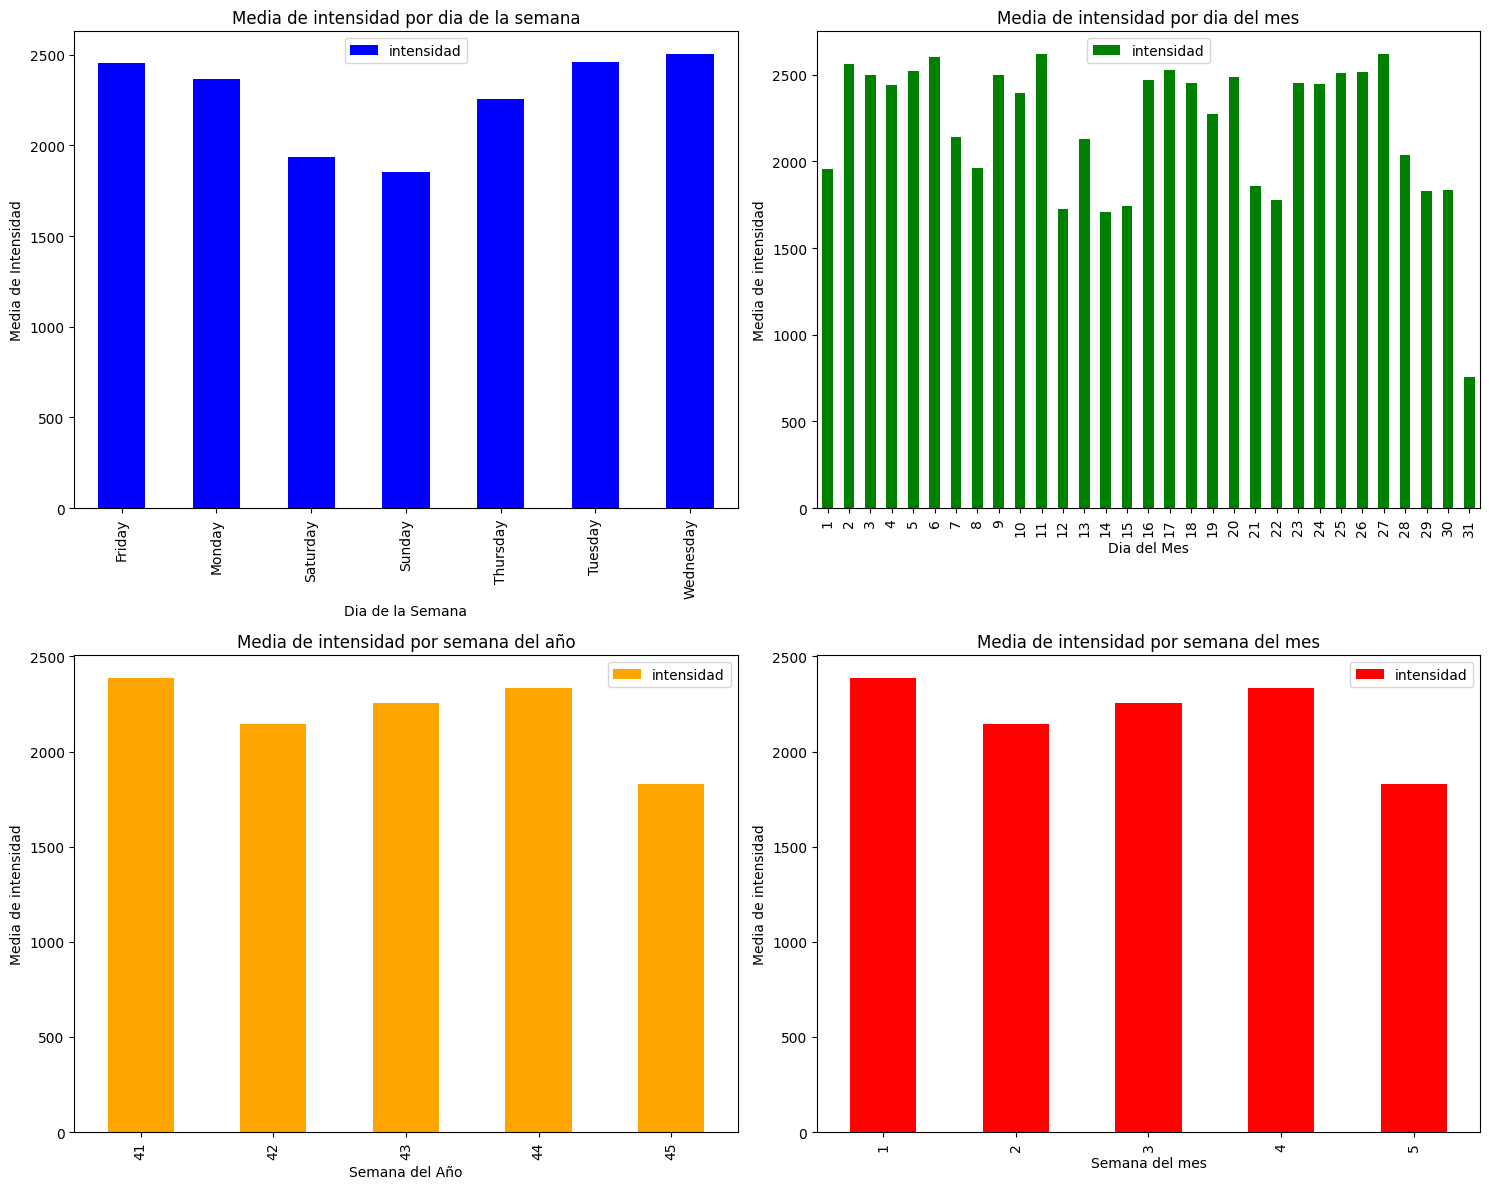

In [132]:
# Definiendo el tamaño de la figura
plt.figure(figsize=(15, 12))

# Intensidad Por dia de la semana
plt.subplot(2, 2, 1)
dia_semana.plot(x='dia_semana', y='intensidad', kind='bar', color='blue', ax=plt.gca())
plt.title('Media de intensidad por dia de la semana')
plt.xlabel('Dia de la Semana')
plt.ylabel('Media de Intensidad')

# Por dia del mes
plt.subplot(2, 2, 2)
dia_mes.plot(x='dia_mes', y='intensidad', kind='bar', color='green', ax=plt.gca())
plt.title('Media de intensidad por dia del mes')
plt.xlabel('Dia del Mes')
plt.ylabel('Media de intensidad')

# Por semana del año
plt.subplot(2, 2, 3)
por_semana_ano.plot(x='semana_ano', y='intensidad', kind='bar', color='orange', ax=plt.gca())
plt.title('Media de intensidad por semana del año')
plt.xlabel('Semana del Año')
plt.ylabel('Media de intensidad')

# Por semana del mes
plt.subplot(2, 2, 4)
por_semana_mes.plot(x='semana_mes', y='intensidad', kind='bar', color='red', ax=plt.gca())
plt.title('Media de intensidad por semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Media de intensidad')

plt.tight_layout()
plt.show()

Hago lo mismo para gráficos de velocidad en subplots, asignando uno para cada conjunto de información.

In [ ]:
# Definiendo el tamaño de la figura
plt.figure(figsize=(15, 12))

# Velocidad Media Por dia de la semana
plt.subplot(2, 2, 1)
dia_semana.plot(x='dia_semana', y='vmed', kind='bar', color='blue', ax=plt.gca())
plt.title('Velocidad Media por dia de la semana')
plt.xlabel('Dia de la Semana')
plt.ylabel('Velocidad Media')

# Por dia del mes
plt.subplot(2, 2, 2)
dia_mes.plot(x='dia_mes', y='vmed', kind='bar', color='green', ax=plt.gca())
plt.title('Velocidad Media por dia del mes')
plt.xlabel('Dia del Mes')
plt.ylabel('Velocidad Media')

# Por semana del año
plt.subplot(2, 2, 3)
por_semana_ano.plot(x='semana_ano', y='vmed', kind='bar', color='orange', ax=plt.gca())
plt.title('Velocidad Media por semana del año')
plt.xlabel('Semana del Año')
plt.ylabel('Velocidad Media')

# Por semana del mes
plt.subplot(2, 2, 4)
por_semana_mes.plot(x='semana_mes', y='vmed', kind='bar', color='red', ax=plt.gca())
plt.title('Velocidad Media por emana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Velocidad Media')

plt.tight_layout()
plt.show()

5. Para los sensores identificados como más relevantes, realizar gráficas comparativas que permitan visualizar las diferencias de tráfco medidas por cada uno de ellos, bien dentro de una misma gráfica o como subplots.

Creé un código que permite al usuario insertar oligatoriamente 4 sensores para su comparación. Este código incluye un bucle de repetición while que solo se cierra cuando se han ingresado 4 sensores válidos. Se realiza una validación en contra de una lista de sensores creada a partir de la búsqueda de todos los ID presentes en el dataset principal, y solo se añaden a la lista de selecionados aquellos sensores que existen en la lista principal. Además, hay una validación para asegurar que si el usuario inserta algo que no sea un número entero, el código no lo registra y le informa el error. Dado que esta validación también se encuentra dentro del bucle while, el código solicitará al usuario que ingrese otro sensor válido. Este conjunto de validaciones garantiza que se utilicen datos correctos y evita la inserción de información incorrecta.

In [133]:
sensores_relevantes = []  # Lista para almacenar los sensores seleccionados
all_sensors = datos_madrid_trafico['id'].unique().tolist()
sensores_necesarios = 4
sensores_ingresados = 0

while sensores_ingresados < sensores_necesarios:
    try:
        sensor_id = int(input("Ingrese el número del sensor que desea agregar al análisis: "))
        
        # Validar si el sensor existe
        if sensor_id in all_sensors:
            sensores_sel = datos_madrid_trafico[datos_madrid_trafico['id'] == sensor_id]
            sensores_relevantes.append(sensores_sel)
            sensores_ingresados += 1
            print(f"Sensor {sensor_id} agregado al análisis.")
        else:
            print("Entrada no válida. El sensor no existe. Por favor, elija un sensor válido.")
    except ValueError:
        print("Entrada no válida. Por favor, ingrese un número válido.")


# Concatenar la lista de DataFrames en un único DataFrame
sensores_relevantes = pd.concat(sensores_relevantes, ignore_index=True)

Sensor 3488 agregado al análisis.
Sensor 6666 agregado al análisis.
Sensor 9999 agregado al análisis.
Entrada no válida. El sensor no existe. Por favor, elija un sensor válido.
Sensor 4444 agregado al análisis.


Me basé en el ejercicio anterior para realizar los análisis. Es decir, creé campos nuevos en el dataset de los sensores relevantes con el fin de agrupar los datos y obtener una comprensión de su temporalidad.

In [134]:
sensores_relevantes['fecha'] = pd.to_datetime(sensores_relevantes['fecha'])
sensores_relevantes['dia_semana'] = sensores_relevantes['fecha'].dt.day_name()
sensores_relevantes['dia_mes'] = sensores_relevantes['fecha'].dt.day
sensores_relevantes['semana_ano'] = sensores_relevantes['fecha'].dt.strftime('%U').astype(int) + 1  # Adding 1 to make it 1-based
sensores_relevantes['semana_mes'] = (sensores_relevantes['fecha'].dt.day - 1) // 7 + 1

In [135]:
sensores_relevantes.head(100)

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,dia_semana,dia_mes,semana_ano,semana_mes
0,3488,2023-10-01 00:00:00,M30,2016,4.0,47,85.0,N,15,Sunday,1,41,1
1,3488,2023-10-01 00:15:00,M30,1881,4.0,46,83.0,N,15,Sunday,1,41,1
2,3488,2023-10-01 00:30:00,M30,1912,5.0,43,82.0,N,15,Sunday,1,41,1
3,3488,2023-10-01 00:45:00,M30,1692,5.0,42,84.0,N,15,Sunday,1,41,1
4,3488,2023-10-01 01:00:00,M30,1532,4.0,38,84.0,N,15,Sunday,1,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3488,2023-10-01 23:45:00,M30,1560,4.0,36,87.0,N,15,Sunday,1,41,1
96,3488,2023-10-02 00:00:00,M30,1572,4.0,37,87.0,N,15,Monday,2,41,1
97,3488,2023-10-02 00:15:00,M30,1313,2.0,33,88.0,N,15,Monday,2,41,1
98,3488,2023-10-02 00:30:00,M30,984,2.0,23,88.0,N,15,Monday,2,41,1


Cree una función para evitar repetir el proceso al crear gráficas. La función plot_sensor_data recibe 3 variables: el dataframe que se utilizará, la variable temporal (ya sea dia_semana, dia_mes, semana_ano o semana_mes) y la última que es el dato a calcular (intensidad o velocidad).

Dentro de la función, se siguen los siguientes pasos:

1. Se extraen los identificadores únicos de los sensores presentes en el DataFrame proporcionado (dataframe).
2. Se determina el número de filas y columnas necesarias para organizar los subgráficos en función del número de sensores utilizando la función len, y se establece un límite de 2 columnas para mantener una visualización clara.
3. Se crea una figura que contiene subgráficos para cada sensor utilizando el número de líneas y columnas pre determinados.
4. Se itera sobre los identificadores de sensores únicos, donde se filtran los datos relevantes del DataFrame original.
5. Se agrupan los datos en función de la variable temporal especificada (temporal_variable). Se utiliza un condicional para interactuar con la información pasada y definir qué fórmula se tiene que utilizar, calculando la media de la variable de interés (variable) para cada categoría temporal.
6. Se utiliza Seaborn para generar gráficos de líneas para cada sensor, mostrando la variación de la variable a lo largo del tiempo y personalizando cada subgráfico con el nombre del sensor, etiquetas de ejes y leyendas.

In [139]:
def plot_sensor_data(dataframe, temporal_variable, variable):
    #Parte 1
    sensor_ids = dataframe['id'].unique()
    
    #Parte 2
    num_sensors = len(sensor_ids)
    num_cols = min(num_sensors, 2)
    num_rows = (num_sensors + num_cols - 1) // num_cols
    
    #Parte 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()

    #Parte 4

    for i, sensor_id in enumerate(sensor_ids):
        sensor_data = dataframe[dataframe['id'] == sensor_id]

        #Parte 5    

        if temporal_variable == 'dia_semana':
            sensor_data = sensor_data.groupby('dia_semana').agg({variable: 'mean'}).reset_index()
        elif temporal_variable == 'dia_mes':
            sensor_data = sensor_data.groupby('dia_mes').agg({variable: 'mean'}).reset_index()
        elif temporal_variable == 'semana_ano':
            sensor_data = sensor_data.groupby('semana_ano').agg({variable: 'mean'}).reset_index()
        elif temporal_variable == 'semana_mes':
            sensor_data = sensor_data.groupby('semana_mes').agg({variable: 'mean'}).reset_index()

        #Parte 6
        sns.lineplot(x=temporal_variable, y=variable, data=sensor_data, ax=axes[i], label=variable.capitalize())
        axes[i].set_title(f'Sensor {sensor_id}')
        axes[i].set_xlabel(temporal_variable.capitalize())
        axes[i].set_ylabel(variable.capitalize())
        axes[i].legend()

    plt.tight_layout()
    plt.show()


 Comparaciones de intensidad por día de la semana de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `dia_semana`, y el campo que queremos calcular, que en este caso es `intensidad`.

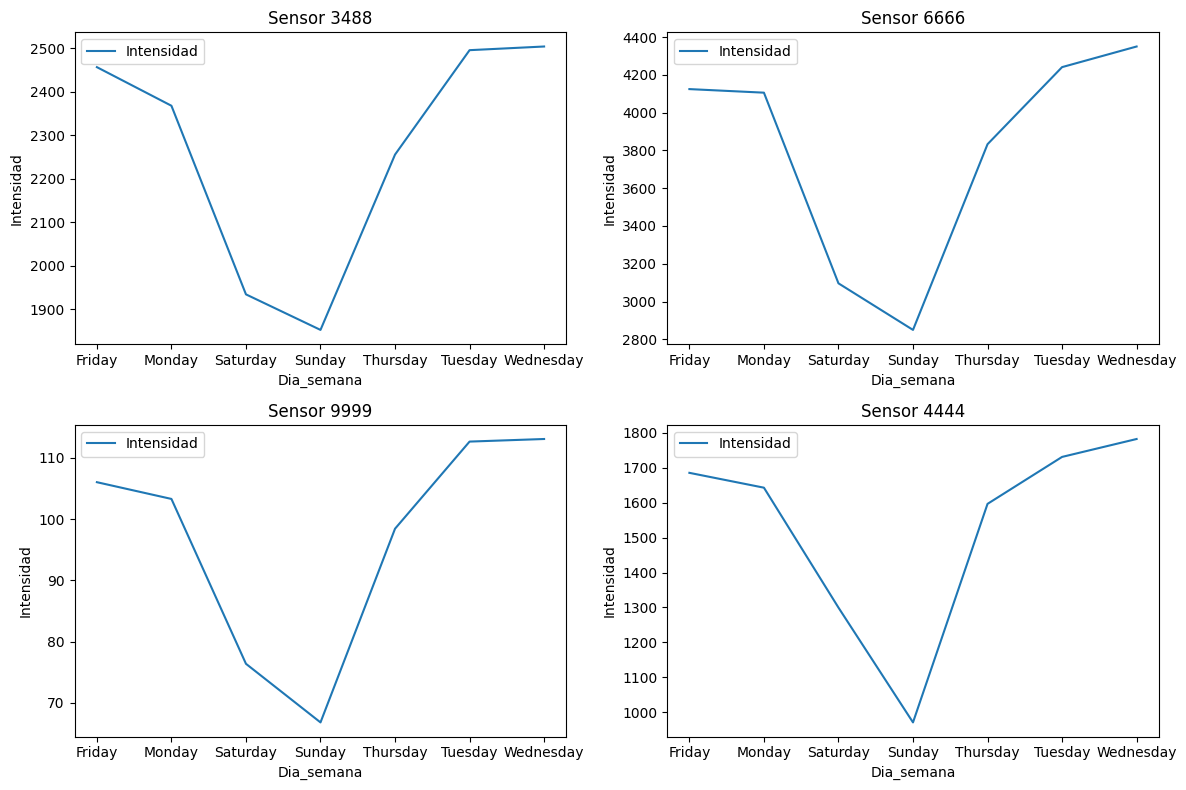

In [138]:
plot_sensor_data(sensores_relevantes, 'dia_semana', 'intensidad')

 Comparaciones de intensidad por día del mes  de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `dia_mes`, y el campo que queremos calcular, que en este caso es `intensidad`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'dia_mes', 'intensidad')

 Comparaciones de intensidad por semana del año de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `semana_ano`, y el campo que queremos calcular, que en este caso es `intensidad`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'semana_ano', 'intensidad')

 Comparaciones de intensidad por semana del mes de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `semana_mes`, y el campo que queremos calcular, que en este caso es `intensidad`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'semana_mes', 'intensidad')

Comparciones de las velocidades de los sensore relevantes selecionados

 Comparaciones de intensidad por semana del mes de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `dia_semana`, y el campo que queremos calcular, que en este caso es `vmed`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'dia_semana', 'vmed')

 Comparaciones de intensidad por semana del mes de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `dia_mes`, y el campo que queremos calcular, que en este caso es `vmed`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'dia_mes', 'vmed')

 Comparaciones de intensidad por semana del mes de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `semana_ano`, y el campo que queremos calcular, que en este caso es `vmed`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'semana_ano', 'vmed')

 Comparaciones de intensidad por semana del mes de los sensores seleccionados. En la función, indicamos el dataframe `sensores_relevantes`, la variable temporal `semana_mes`, y el campo que queremos calcular, que en este caso es `vmed`.

In [ ]:
plot_sensor_data(sensores_relevantes, 'semana_mes', 'vmed')